In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
df = YahooDownloader(start_date = '2011-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.SENSEX_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2011-01-03,289.799988,294.880005,286.019989,263.478271,107300.0,ASIANPAINT.BO,0
1,2011-01-03,271.450012,274.399994,268.429993,252.560455,1603895.0,AXISBANK.BO,0
2,2011-01-03,1559.949951,1564.949951,1470.000000,1108.281006,114420.0,BAJAJ-AUTO.BO,0
3,2011-01-03,456.908142,466.635864,453.223419,457.380585,5717.0,BAJAJFINSV.BO,0
4,2011-01-03,68.483635,68.488495,67.517021,64.054718,17478.0,BAJFINANCE.BO,0


In [7]:
df.shape

(73830, 8)

In [8]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_turbulence=False,
                    use_vix=False,
                    use_sentiment=True,
                    sentiment_df=sentiment_df,
                    user_defined_feature = True)

processed = fe.preprocess_data(df)

Successfully added Sentiment Features
Successfully added user defined features


In [10]:
processed.head()

,date,open,high,low,close,volume,tic,day,tweets,news,daily_return,return_lag_1,return_lag_2
90,2011-01-06,289.799988,289.799988,284.100006,260.857086,41860.0,ASIANPAINT.BO,3,0.0,0.0,-0.007549,0.002978,-0.009948
91,2011-01-06,264.410004,264.410004,260.010010,241.443100,603950.0,AXISBANK.BO,3,0.0,0.0,-0.002632,-0.029687,-0.044019
92,2011-01-06,1392.000000,1393.000000,1321.000000,996.826477,276347.0,BAJAJ-AUTO.BO,3,0.0,0.0,-0.036036,-0.071581,-0.100565
93,2011-01-06,459.855957,459.855957,444.281769,440.109985,5424.0,BAJAJFINSV.BO,3,0.0,0.0,-0.026609,-0.030666,-0.037760
94,2011-01-06,69.848549,69.848549,66.934143,62.775913,37942.0,BAJFINANCE.BO,3,0.0,0.0,-0.008339,-0.007697,-0.019964


In [11]:
train = data_split(processed, '2011-01-01','2019-01-01')
train

,date,open,high,low,close,volume,tic,day,tweets,news,daily_return,return_lag_1,return_lag_2
0,2011-01-06,289.799988,289.799988,284.100006,260.857086,41860.0,ASIANPAINT.BO,3,0.000000,0.000000,-0.007549,0.002978,-0.009948
0,2011-01-06,264.410004,264.410004,260.010010,241.443100,603950.0,AXISBANK.BO,3,0.000000,0.000000,-0.002632,-0.029687,-0.044019
0,2011-01-06,1392.000000,1393.000000,1321.000000,996.826477,276347.0,BAJAJ-AUTO.BO,3,0.000000,0.000000,-0.036036,-0.071581,-0.100565
0,2011-01-06,459.855957,459.855957,444.281769,440.109985,5424.0,BAJAJFINSV.BO,3,0.000000,0.000000,-0.026609,-0.030666,-0.037760
0,2011-01-06,69.848549,69.848549,66.934143,62.775913,37942.0,BAJFINANCE.BO,3,0.000000,0.000000,-0.008339,-0.007697,-0.019964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,2018-12-31,429.799988,432.299988,425.649994,419.215668,464991.0,SUNPHARMA.BO,0,-0.033368,0.039227,0.014249,0.044506,0.040217
1965,2018-12-31,1901.000000,1910.150024,1887.000000,1782.842896,155314.0,TCS.BO,0,0.000000,0.046776,-0.001187,-0.008327,0.002143
1965,2018-12-31,716.000000,724.200012,715.400024,660.063171,50512.0,TECHM.BO,0,0.000000,-0.124014,0.012354,0.018359,0.038077
1965,2018-12-31,928.000000,939.000000,920.700012,916.568787,163019.0,TITAN.BO,0,0.000000,0.031650,0.008076,0.047064,0.045887


In [12]:
sent = 1
tech = 0
user = 1
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + (tech*len(config.TECHNICAL_INDICATORS_LIST)+sent*len(config.SENTIMENT_INDICATORS_LIST)+user*len(config.USER_INDICATORS_LIST))*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 211


In [13]:
env_kwargs = {
    "hmax": 1000, 
    "initial_amount": 10000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    # "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "tech_indicator_list": [],
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    # "user_indicator_list": [],
    "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "turbulence_threshold": None,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

# print(config.TECHNICAL_INDICATORS_LIST,config.SENTIMENT_INDICATORS_LIST,config.USER_INDICATORS_LIST)

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [15]:
# initialize
agent = DRLAgent(env = env_train)
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.005}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_6
------------------------------------
| time/                 |          |
|    fps                | 73       |
|    iterations         | 100      |
|    time_elapsed       | 6        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.000598 |
|    learning_rate      | 0.005    |
|    n_updates          | 99       |
|    policy_loss        | -398     |
|    std                | 1.01     |
|    value_loss         | 122      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 62       |
|    iterations         | 200      |
|    time_elapsed       | 15       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 3.71e-05 |


In [16]:
trade = data_split(processed,'2019-01-01', '2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [17]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [18]:
df_daily_return.to_csv('df_returns.csv')

In [19]:
df_actions.to_csv('df_actions.csv')

In [20]:
from pyfolio import timeseries
s1 = get_daily_return(df_daily_return, value_col_name="account_value")
df_daily_return['daily_return'] = s1.values
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [21]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.390674
Cumulative returns     0.903841
Annual volatility      0.243427
Sharpe ratio           1.480692
Calmar ratio           1.204293
Stability              0.813272
Max drawdown          -0.324401
Omega ratio            1.339522
Sortino ratio          2.162704
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.087279
Daily value at risk   -0.029239
Alpha                  0.000000
Beta                   1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (490, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,23
,Backtest
Annual return,39.438%
Cumulative returns,90.872%
Annual volatility,24.366%
Sharpe ratio,1.49
Calmar ratio,1.22
Stability,0.82
Max drawdown,-32.44%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.44,2020-02-19,2020-03-23,2020-09-18,153
1,7.59,2019-02-07,2019-02-18,2019-03-26,34
2,7.49,2020-09-18,2020-09-24,2020-10-27,28
3,7.00,2019-07-02,2019-07-25,2019-09-09,50
4,5.32,2019-04-30,2019-05-14,2019-05-21,16


Stress Events,mean,min,max
New Normal,0.14%,-12.61%,9.70%


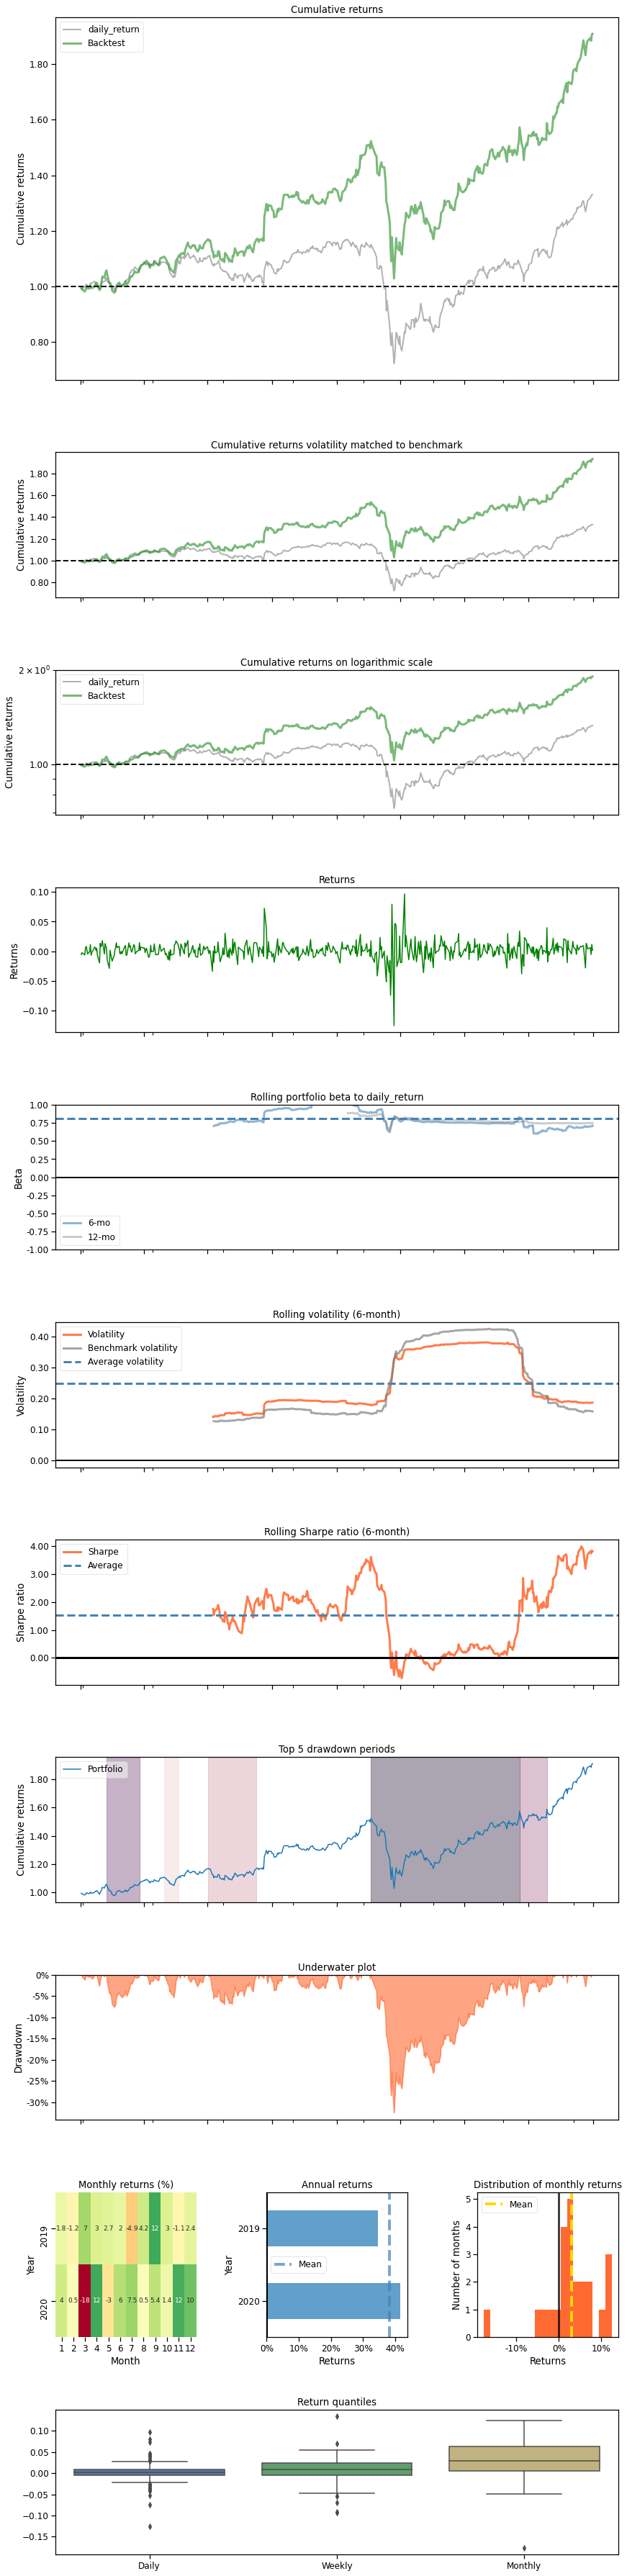

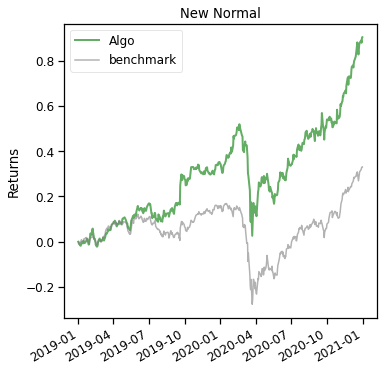

In [22]:
import pyfolio
import datetime as dt
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-01-01', end='2021-01-01')


baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)